# This notebook contains code for creating and evaluating the baseline model and subsequent models

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

import imblearn.over_sampling

In [2]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [3]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in dataset for modeling

In [4]:
df_X = pd.read_csv('nypd_force_df.csv')

In [5]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'forcetype_Firearm',
       'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION', 'basis_encounter_OTHER',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_TRANSIT EJECTION',
       'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)',
     

# Model Preparation

First, since I'm using logistic regression and I have numeric variables on different scales, I need to standardize them so they're on the same scale.

In [6]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age','incidents_per_season']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

Next, I split my dataset twice: first, into training and test sets on randomly selected groups of non-NYPD subjects, so there isn't any overlap in the non-NYPD subjects in either set.

Then, I split the training set again into training and validation sets.

In [7]:
# split the data into train/validate/test sets on randomly selected groups of non-NYPD subjects

# all data -> train / test
np.random.seed(42)
total_subjects = df_X['subject_id'].unique() 
test_subjects = np.random.choice(total_subjects, size=int(total_subjects.shape[0] * .20))

df_X_tr_val, df_X_te = df_X[~df_X['subject_id'].isin(test_subjects)], df_X[df_X['subject_id'].isin(test_subjects)]


y_tr_val, y_te = df_X_tr_val['subject_injured'], df_X_te['subject_injured']
X_tr_val, X_te = df_X_tr_val.drop(['subject_id','tri_incident_number','subject_injured'],axis=1), \
             df_X_te.drop(['subject_id','tri_incident_number','subject_injured'],axis=1)


# train -> train / validation
X_tr, X_val, y_tr, y_val = train_test_split(X_tr_val, y_tr_val, test_size=.25, random_state=42)

Now that I have my dataset ready, I can create a helper function that will allow me to fit a model and cross-validate it using F2 and recall scores as my evaluation metrics.

In [8]:
def lr_model_cross_validate(X,y):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    
    lr.fit(X,y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results_lr = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recall scores: {(cv_results_lr['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results_lr['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results_lr['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results_lr['test_f2_score'])):.3f}")

# Baselining Model

I'm ready to create my baseline model!

In [9]:
lr_model_cross_validate(X_tr,y_tr)

recall scores: [0.03333333 0.07407407 0.08333333 0.09677419 0.        ]

mean recall: 0.058

f2 scores: [0.04132231 0.09009009 0.10135135 0.1171875  0.        ]

mean f2 score: 0.070


These scores are very close to zero, so I have a lot of room for improvement.

Next, I'll calculate the ROC curve, plot it, and then calculate the ROC AUC score using validation data.

In [10]:
# instantiate the model and fit it (I have to do this again, since when I did it above, it was within a function)

lr_base = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_base.fit(X_tr, y_tr)

LogisticRegression(max_iter=10000)

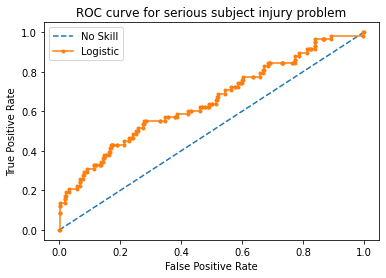

ROC AUC score =  0.6531757697160473


In [11]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, lr_base.predict_proba(X_val)[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, lr_base.predict_proba(X_val)[:,1]))

# Second Model

Because my dataset is very imbalanced (approximately 98% are in the negative class and 2% are in the positive class), I'm choosing to deal with this first by oversampling and hopefully improve my model.

Since I'm not sure what the best ratio is to use, I'm going to try out several and plot the scores versus the ratio value to pick the optimal one.

Logistic Regression Model best F2 score 0.186 at ratio = 18 to 1


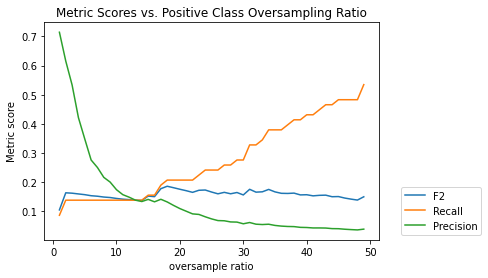

In [12]:
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)
    
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    lr.fit(X_tr_rs,y_tr_rs)
    
    f2_scores.append(fbeta_score(y_val, lr.predict(X_val), beta=2))    
    rec_scores.append(recall_score(y_val, lr.predict(X_val)))
    prec_scores.append(precision_score(y_val, lr.predict(X_val)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Logistic Regression Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

Now that I know the optimal F2 score is with a ratio of 18 to 1 for positives to negatives, I'm going to oversample using this ratio for my second model.

In [13]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 18, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

In [14]:
lr_model_cross_validate(X_tr_rs,y_tr_rs)

recall scores: [0.25668449 0.22568807 0.22103387 0.20767888 0.25352113]

mean recall: 0.233

f2 scores: [0.29666255 0.26248399 0.25556472 0.24355301 0.29363785]

mean f2 score: 0.270


This is an improvement. The base had much lower mean recall and F2 scores and there was much more variance in each fold's scores.

Next, I'll create confusion matrices to further evaluate the performance of the second model. I'll use separate training and validation data to do this.

In [15]:
# instantiate the model and fit it (I have to do this again, since when I did it above, it was within a function)

lr_2 = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_2.fit(X_tr_rs, y_tr_rs)

LogisticRegression(max_iter=10000)

Confusion matrix of second model using training data

Text(115.7222222222223, 0.5, 'Actual serious injury')

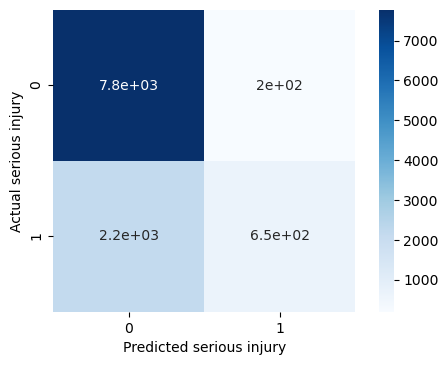

In [16]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_2.predict(X_tr_rs))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

Confusion matrix of second model using validation data

Text(115.7222222222223, 0.5, 'Actual serious injury')

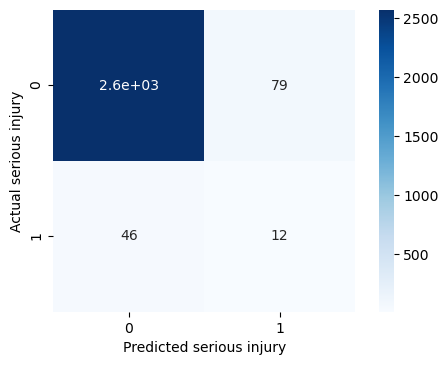

In [17]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val, lr_2.predict(X_val))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

By comparing the confusion matrices using first the training data and then the validation data, we can see that recall score for the training dataset is 650/(650+2200) = ~ 22%. Meanwhile, with the validation data, the recall score is 12/(12+46) = ~ 20%. The good thing is that they're not wildly different from each other, but I'd like them to be higher.

Precision is lower for the training data (650/(200+650) = ~76%) but markedly lower for the validation data (12/(12+79) = ~13%). While I ultimately care more about recall than precision, it would be good if these values weren't so drastically different.

Next, I'll plot the ROC curve for the second model. I'll use validation data for this.

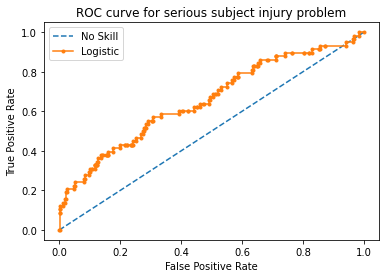

ROC AUC score =  0.658274691398171


In [18]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, lr_2.predict_proba(X_val)[:,1]) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, lr_2.predict_proba(X_val)[:,1]))

The ROC AUC score is nearly identical to that of the base model.

In [21]:
scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_results_2_val = cross_validate(lr_2, X_val, y_val, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_2_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_2_val['test_rec'])):.3f}")
print("")
print(f"F2 scores: {(cv_results_2_val['test_f2_score'])}")
print("")
print(f"mean F2 score: {(np.mean(cv_results_2_val['test_f2_score'])):.3f}")

recall scores: [0.         0.08333333 0.07692308 0.         0.        ]

mean recall score: 0.032

F2 scores: [0.         0.10204082 0.09433962 0.         0.        ]

mean F2 score: 0.039


Wow, the mean recall and F2 scores from cross-validation using validation data suggests that this model still needs a lot of improvement!

Next, I will try further addressing the class imbalance issue by experimenting with adjusting class weights. Since I'm not sure what the optimal class weight ratio is, I'm going to experiment with different values.

# Third model

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

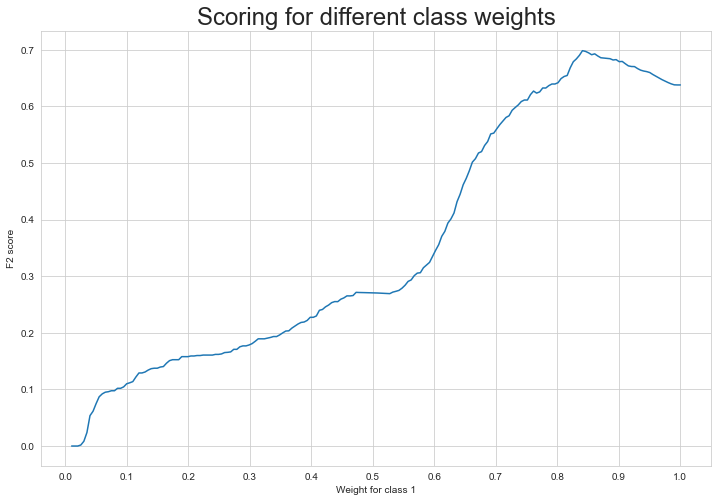

In [22]:
# I got help with writing this code from this webpage: https://developpaper.com/using-class-weight-to-improve-class-imbalance/

lr_weight = LogisticRegression(solver='lbfgs')

#Define scoring metrics

f2_score = make_scorer(fbeta_score, beta=2)

#Set the range of class weights
weights = np.linspace(0.0,0.99,200)

#Create dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

##Fitting training data with 5 times grid search method
gridsearch = GridSearchCV(estimator= lr_weight, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=f2_score, 
                          verbose=2,
                          refit=False).fit(X_tr_rs, y_tr_rs)

#Draw fractions with different weight values
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weight_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weight_data['weight'], weight_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F2 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

From the above graph, it looks like about .84 is the optimal class weight for class 1. Let's confirm with some more code:

In [23]:
weight_data['score'].argmax()
weight_data.iloc[32,:]

score     0.698455
weight    0.840804
Name: 32, dtype: float64

Indeed, GridSearchCV helped us identify the optimal weight for class 1 to be 0.840804, meaning the class weight for class 0 will be 1-0.840804=0.159196.

Next, we'll apply these class weights to our third model and see how it performs.

In [24]:
scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
lr_3 = LogisticRegression(class_weight={1 : 0.840804, 0 : 0.159196},solver='lbfgs',max_iter=10000)
lr_3.fit(X_tr_rs, y_tr_rs)
    
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_results_3 = cross_validate(lr_3, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)
    
# Report results
    
print(f"recall scores: {(cv_results_3['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_3['test_rec'])):.3f}")
print("")
print(f"f2 scores: {(cv_results_3['test_f2_score'])}")
print("")
print(f"mean f2 score: {(np.mean(cv_results_3['test_f2_score'])):.3f}")

recall scores: [0.91265597 0.89541284 0.91622103 0.93717277 0.93838028]

mean recall score: 0.920

f2 scores: [0.69226609 0.67627494 0.69647696 0.71352644 0.70972037]

mean f2 score: 0.698


So far, these average recall and F2 scores look much better for model 3 compared to those of model 2 (as a reminder, the mean recall score for model 2 was 0.233 and the mean F2 score was 0.270).

Next, I'll create confusion matrices on training and validation sets to further evaluate model 3's performance.

Confusion matrix for third model with training data

Text(117.7222222222223, 0.5, 'Actual serious injury')

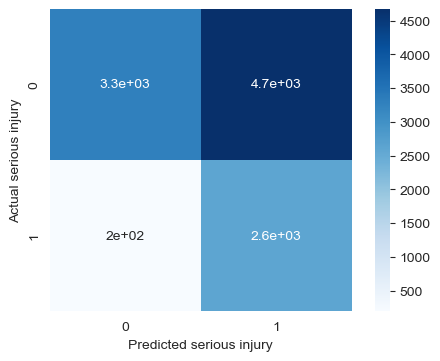

In [25]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_3.predict(X_tr_rs))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

Confusion matrix for third model with validation data

Text(117.7222222222223, 0.5, 'Actual serious injury')

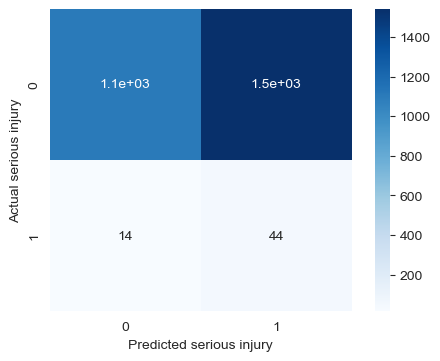

In [26]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val, lr_3.predict(X_val))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

The above matrices indicate that on the training data, the recall score is 2600/(2600+200) = ~93% (in model two, the score was ~22%). Meanwhile, for the validation data, it's 44/(14+44) = ~76% (in model two, it was ~20%). These scores vary widely, suggesting that my model is overfitting to the training data. 

Precision is lower for the training data (2600/(2600+2700) = ~49%) but markedly lower for the validation data (44/(44+1500) = ~2%).

Below is the ROC curve and ROC AUC scores for the third model.

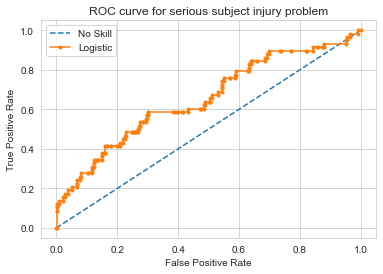

ROC AUC score =  0.6548862498211474


In [27]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, lr_3.predict_proba(X_val)[:,1]) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, lr_3.predict_proba(X_val)[:,1]))

Both the curve and the score are roughly the same as they were for model 2.

Below are the cross-validation results of model 3 using validation data.

In [28]:
cv_results_3_val = cross_validate(lr_3, X_val, y_val, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_3_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_3_val['test_rec'])):.3f}")
print("")
print(f"F2 scores: {(cv_results_3_val['test_f2_score'])}")
print("")
print(f"mean F2 score: {(np.mean(cv_results_3_val['test_f2_score'])):.3f}")

recall scores: [0.         0.08333333 0.07692308 0.18181818 0.23076923]

mean recall score: 0.115

F2 scores: [0.         0.10204082 0.09259259 0.21276596 0.27272727]

mean F2 score: 0.136


The mean mean recall and F2 scores are still extremely low but ever so slightly better than those of model 2, so that means we're headed in the right direction.

Next, I'll use gridsearch again to hypertune the value of C and identify redundant features that can be removed.

# Fourth model

In [29]:
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(class_weight={1 : 0.840804, 0 : 0.159196}, penalty='l1',solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_tr_rs, y_tr_rs)

# Train a LR model with best parameters
lr_4 = LogisticRegression(**gs_model.best_params_, class_weight={1 : 0.840804, 0 : 0.159196},penalty='l1', solver='liblinear')
lr_4.fit(X_tr_rs, y_tr_rs)

LogisticRegression(C=1, class_weight={0: 0.159196, 1: 0.840804}, penalty='l1',
                   solver='liblinear')

In [30]:
print(np.round(lr_4.coef_[0],0))

[ 3.  1. -4. -0.  0.  0.  2.  0.  2. -1.  1. -0.  0.  3.  1. -1.  1. -0.
  0.  1.  2. -1.  1.  1.  0.  2.  0.  0.  1. -0. -0.  0. -1. -0. -0. -1.
 -0. -0. -0.  0.  0.  0.  0. -1. -1. -0. -0.  0.  0. -0.  0. -0.]


The coefficents rounded to zero are the redundant features.

In [31]:
coef = np.round(lr_4.coef_[0],0)
useful_features = pd.Series(X_tr_rs.columns)[list(coef!=0)]
print(f"Number of 'useful' features (i.e., those that don't have coefficients of 0): {(len(useful_features))}")
print(f"Number of original features: {(len(lr_4.coef_[0]))}")

Number of 'useful' features (i.e., those that don't have coefficients of 0): 22
Number of original features: 52


Next, I'll update the feature sets for train, val, and test sets so they only include the smaller subset of 22 features for further modeling.

In [32]:
X_tr_rs = X_tr_rs[useful_features]
X_val =  X_val[useful_features]
X_te = X_te[useful_features]

# Fifth model

Now, that I have fewer features, I'll fit a new model with them and do cross-validation.

In [34]:
scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
lr_5 = LogisticRegression(C = 1, class_weight={1 : 0.840804, 0 : 0.159196},solver='lbfgs',max_iter=10000)
lr_5.fit(X_tr_rs, y_tr_rs)
    
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_results_5 = cross_validate(lr_5, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)

# Report results
    
print(f"recall scores: {(cv_results_5['test_rec'])}")
print("")
print(f"mean recall: {(np.mean(cv_results_5['test_rec'])):.3f}")
print("")
print(f"f2 scores: {(cv_results_5['test_f2_score'])}")
print("")
print(f"mean f2 score: {(np.mean(cv_results_5['test_f2_score'])):.3f}")

recall scores: [0.87878788 0.86055046 0.87344029 0.88481675 0.87147887]

mean recall: 0.874

f2 scores: [0.66711773 0.65156988 0.66757493 0.6840259  0.66964286]

mean f2 score: 0.668


Confusion matrix with training data

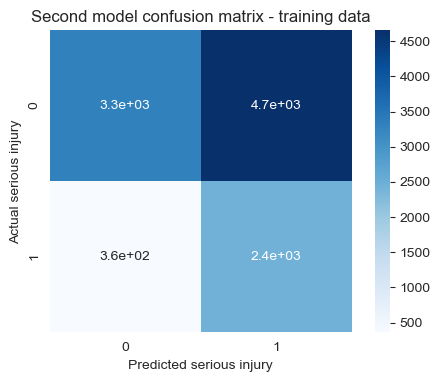

In [35]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_5.predict(X_tr_rs))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Second model confusion matrix - training data');

Confusion matrix with validation data

Text(117.7222222222223, 0.5, 'Actual serious injury')

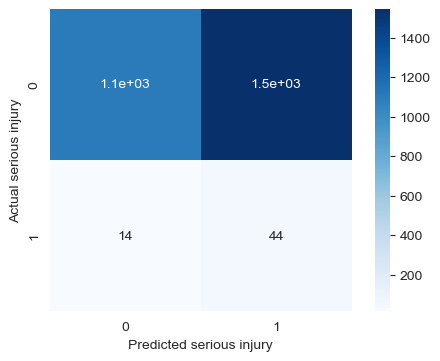

In [36]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val, lr_5.predict(X_val))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

Looking at these the training and validation data set confusion matrices for model 5, we can see that the number of false positives, false negatives, true positives, and true negatives are very similar (in fact, they're exactly the same for the validation dataset). This suggests that removing select features did not improve the model's performance, though it will help with interpretation.

Below is the ROC curve and ROC AUC score for model 5.

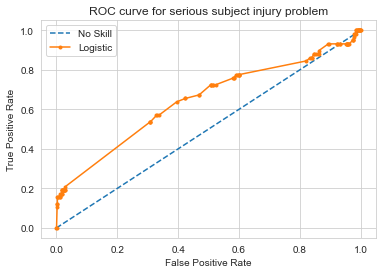

ROC AUC score =  0.6484313011355507


In [37]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, lr_5.predict_proba(X_val)[:,1]) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, lr_5.predict_proba(X_val)[:,1]))

It has actually gotten slightly worse with each model iteration.

Below are the cross-validation results of model 5 using validation data.

In [57]:
cv_results_5_val = cross_validate(lr_5, X_val, y_val, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_5_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_5_val['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_5_val['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_5_val['test_f2_score'])):.3f}")

recall scores: [0.         0.16666667 0.15384615 0.09090909 0.23076923]

mean recall score: 0.128

F2 score scores: [0.         0.19607843 0.1754386  0.11111111 0.27272727]

F2 score score: 0.151


The mean mean recall and F2 scores are still extremely low and the individual splits' scores are extremely varied.

Next, I'll look at the coefficients of my final model 5 to interpret their meanings

In [42]:
lr_5_feature_coeffs = pd.DataFrame({'features': X_tr_rs.columns,
                   'coefficients': lr_5.coef_.flatten()}).\
                    sort_values('coefficients', ascending = False)
lr_5_feature_coeffs

,features,coefficients
0,forcetype_Firearm,3.268771
7,basis_encounter_IN CUSTODY INJURY,2.846804
12,basis_encounter_SEARCH WARRANT,1.890235
1,forcetype_Impact Weapon,1.813168
16,force_against_mos_Cutting Instrument,1.787020
3,basis_encounter_AMBUSH OF MEMBER,1.573260
17,force_against_mos_Impact Weapon,1.368981
4,basis_encounter_CRIME/VIOLATION IN PROGRESS,1.185325
15,"basis_encounter_WANTED SUSPECT (E.G. WARRANT, ...",0.989037
8,basis_encounter_NON-CRIME CALLS FOR SERVICE,0.988699


All of the coefficients come from 5 features in the original dataset, so I will add a column to the feature coefficients dataframe that assigns them to a group. This will help with plotting.

In [43]:
forcetype = 'forcetype'
basis = 'basis_encounter'
force_against = 'force_against_mos'
patrol_borough = 'patrol_borough'
subject_race = 'subject_race'

def feature_group(x):
    if forcetype in x:
        return 1
    elif basis in x:
        return 2
    elif force_against in x:
        return 3
    elif patrol_borough in x:
        return 4
    else:
        return 5

lr_5_feature_coeffs['group'] = lr_5_feature_coeffs['features'].apply(feature_group)
lr_5_feature_coeffs.head()

,features,coefficients,group
0,forcetype_Firearm,3.268771,1
7,basis_encounter_IN CUSTODY INJURY,2.846804,2
12,basis_encounter_SEARCH WARRANT,1.890235,2
1,forcetype_Impact Weapon,1.813168,1
16,force_against_mos_Cutting Instrument,1.787020,3


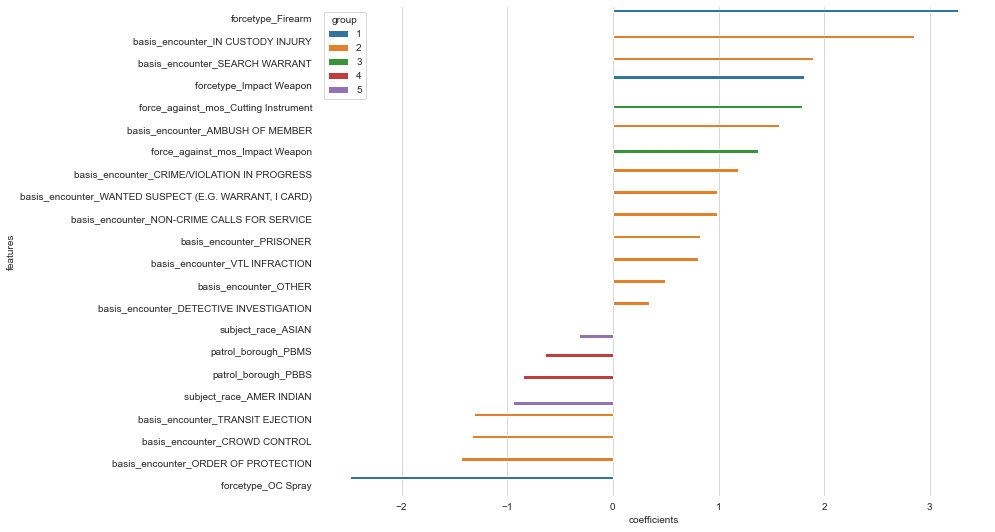

In [44]:
# plot the features and their coefficients
f, ax = plt.subplots(figsize=(12, 9))
sns.set_color_codes("pastel")
sns.barplot(x="coefficients", y="features", data=lr_5_feature_coeffs,hue='group')
sns.despine(left=True, bottom=True)
#plt.savefig('mvp.png',bbox_inches='tight')

The categories for each feature group not included:
- forcetype -> Electrical Weapon (reference category); Physical Force; Police Canine; Restraining Mesh Blanket
- force_against_mos -> No Force (reference category); Firearm; Displayed Weapon; Physical Force
- basis_encounter -> SUSPICIOUS ACTIVITY (reference category); PAST CRIME VIOLATION; HOME VISIT; ANIMAL CONDITION; HOSTAGE BARRICADED
- patrol_borough -> PBBN (reference category), PBBX, PBMN, PBQS, PBQN
- subject_race -> WHITE (reference category), BLACK, HISPANIC, UNK/OTH

To convert the coefficients in log-odds to probabilities, use the following formula:
    
probability = 1 / (1 + exp(-x))

We can make predictions from these coefficients. I got help with how to do this using <a href="https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/">this article</a>.

Let's consider the scenario of an Asian non-NYPD subject who... 
- was involved in an encounter with 1+ NYPD members of service on the basis of a person in crisis c) in the patrol borough of Brooklyn South
- used no force against 1+ NYPD members of service
- and experienced force from 1+ NYPD members of service in the form of an impact weapon (impact weapon includes straight baton, expandable baton, or any object (other than a part of the officer’s body) that is used to strike a subject).

If we compute all the effects and add them up we have - 0.419 (subject Asian = yes) + 0.880 (person in crisis basis for encounter = yes) + 0 (no force against mos = 0) - 0.753 (patrol brough Brooklyn South = yes) + 1.513 (impact weapon force experienced = yes) = 1.221

In [86]:
-.419+.88+0+1.513-.753-1.595

-0.3739999999999999

In [87]:
1 /(1 + np.exp(.374))

0.40757483530004773

We then need to add the intercept (which we get by doing lr_4.intercept_), which gives us 1.221 - 1.595 = -0.374. 

Next, we do the logistic transformation to calculate the probability from this log-odds:

probability = 1 / (1 + exp(-x)) = 1 /(1 + exp(- -0.374)) = ~0.41 = ~41%

Thus, given this model, we would expect that an Asian non-NYPD subject who was involved in an encounter with 1+ members of service on the basis of a person in crisis in the patrol borough of Brooklyn South, didn't use any force against a NYPD member of service, and experienced force in the form of an impact weapon would experience a serious (level 2, 3 or 4) injury approximately 40% of the time.

Alternatively, we would expect a Black, Hispanic or White non-NYPD subject in the same boat - and who also didn't use force against an NYPD member of service - to experience a serious injury approximately 60% of the time.

In [88]:
0+.88+1.513-.753-1.595

0.04499999999999971

In [89]:
1 /(1 + np.exp(-0.449))

0.6104014487007485

Evaluate model with testing data

In [45]:
cv_results_5_te = cross_validate(lr_5, X_te, y_te, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_5_te['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_5_te['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_5_te['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_5_te['test_f2_score'])):.3f}")

recall scores: [0.16666667 0.0625     0.14285714 0.16666667 0.0625    ]

mean recall score: 0.120

F2 score scores: [0.2        0.07575758 0.16393443 0.2        0.07352941]

F2 score score: 0.143


Text(117.7222222222223, 0.5, 'Actual serious injury')

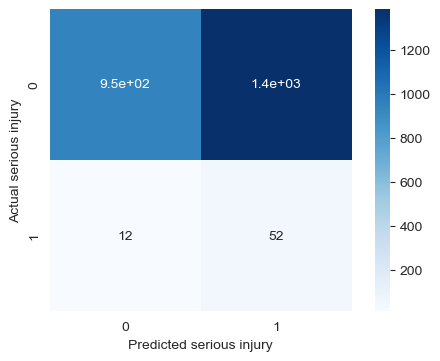

In [46]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_te, lr_5.predict(X_te))
plt.figure(dpi=100)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')

<AxesSubplot:xlabel='subject_injured', ylabel='Count'>

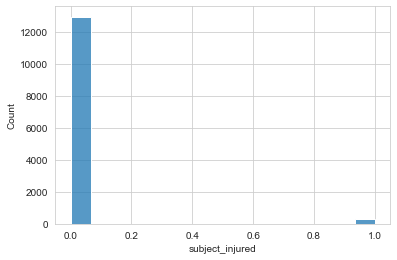

In [50]:
sns.histplot(df_X['subject_injured'])

# Random Forest

In [53]:
rf_model = RandomForestClassifier(class_weight={1 : 0.840804, 0 : 0.159196},random_state=42, n_jobs=-1, verbose = 1)

# Fit on training data
rf_model.fit(X_tr_rs, y_tr_rs)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(class_weight={0: 0.159196, 1: 0.840804}, n_jobs=-1,
                       random_state=42, verbose=1)

Cross-validate with training data

In [54]:
cv_results_rf = cross_validate(rf_model, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_rf['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_rf['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_rf['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_rf['test_f2_score'])):.3f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

recall scores: [0.89304813 0.88807339 0.88235294 0.89179756 0.88908451]

mean recall score: 0.889

F2 score scores: [0.6762959  0.67036011 0.68616579 0.69732533 0.68169546]

F2 score score: 0.682


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Cross-validate with validation data

In [67]:
cv_results_rf_val = cross_validate(rf_model, X_val, y_val, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_rf_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_rf_val['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_rf_val['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_rf_val['test_f2_score'])):.3f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]:

recall scores: [0.         0.25       0.07692308 0.18181818 0.23076923]

mean recall score: 0.148

F2 score scores: [0.         0.28846154 0.08928571 0.2173913  0.27272727]

F2 score score: 0.174


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


ROC curve and ROC AUC score using validation data

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


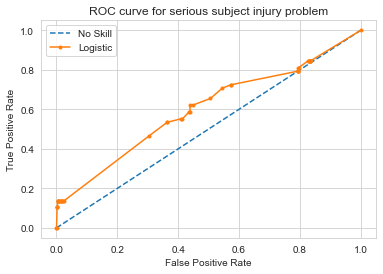

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


ROC AUC score =  0.6017085289871096


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1]) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1]))

# Naive Bayes

In [60]:
nb = BernoulliNB()
nb.fit(X_tr_rs,y_tr_rs)

BernoulliNB()

In [62]:
confusion_matrix(y_tr_rs, nb.predict(X_tr_rs))

array([[7800,  169],
       [2178,  630]])

In [63]:
confusion_matrix(y_val, nb.predict(X_val))

array([[2581,   70],
       [  46,   12]])

In [64]:
cv_results_nb_tr = cross_validate(nb, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_nb_tr['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_nb_tr['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_nb_tr['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_nb_tr['test_f2_score'])):.3f}")

recall scores: [0.24242424 0.21284404 0.21746881 0.19720768 0.23943662]

mean recall score: 0.222

F2 score scores: [0.2822748  0.24946237 0.25269263 0.23203285 0.27868852]

F2 score score: 0.259


In [65]:
cv_results_nb_val = cross_validate(nb, X_val, y_val, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_nb_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_nb_val['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_nb_val['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_nb_val['test_f2_score'])):.3f}")

recall scores: [0.         0.         0.15384615 0.         0.        ]

mean recall score: 0.031

F2 score scores: [0.        0.        0.1754386 0.        0.       ]

F2 score score: 0.035


ROC curve and ROC AUC score using validation data

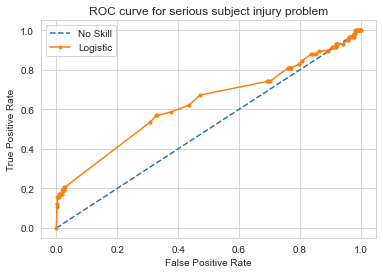

ROC AUC score =  0.6301590811535009


In [68]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val, nb.predict_proba(X_val)[:,1]) 

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val, nb.predict_proba(X_val)[:,1]))